# Sales Rate Prediction

### Problem Statement:

In this notebook, we aim to predict the rate of sale for a given product. A sample dataset has been provided to explore and potentially produce a working prototype.

You will need to present your thoughts and approach on this back to us where we are looking at what you produced in the  prototype, understanding of the dataset, and your thoughts to a long term approach and options moving forward.

### Considerations:
- Prototype in any language/framework as you see fit
- What Logic based approaches, ML, Deep learning options are there?
- What a long term option may look like and how would an iterative approach to delivering look like
- What additional data may help improve your approach?
- How can you make the results from your approach reproducible?

### Data Definitions:
The dataset provided consists of a selection of product attributes along with some high level sales data. The columns are defined as follows:
- ProductNumber: Unique ID of the product
- ProductSkuCode: Unique ID of the product along with the size code
- ProductSize: Size of the product
- ProductDivision: Numerical encoding of the product's division
- ProductDepartment: Numerical encoding of the product's department
- ProductGroup: Numerical encoding of the product's group
- ProductCategory: Numerical encoding of the product's category
- ProductSizeGroupDescription: Numerical encoding of the product's size group description
- ProductOriginalUnitPriceGBP: Price of the product in GBP
- ProductMaxDaysToSellinFullPrice: The maximum number of days the product was sold at full price
- Season: Numerical encoding of the season the product was sold in
- FullPriceUnits: Number of full price units sold
- RateofSales: The rate of the sale of the product at the size level

Rate of sale formula: FullPriceUnits / ProductMaxDaysToSellinFullPrice

# Data Exploration and Preparation

## Loading the data

- This section includes loading of the data, understanding basic description of the data; followed by cleanup & imputations if required.

In [2]:
# Importing the required packages

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
import category_encoders as ce

# from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Loading the dataset and previewing the shape of the dataframe

sales_data = pd.read_csv('dataset.csv')
print("The shape of the sales data is:",sales_data.shape)

The shape of the sales data is: (10528, 13)


In [4]:
# Previewing the data

sales_data.head(5)

,ProductNumber,ProductSkuCode,ProductSize,ProductDivision,ProductDepartment,ProductGroup,ProductCategory,ProductSizeGroupDescription,ProductOriginalUnitPriceGBP,ProductMaxDaysToSellInFullPrice,Season,FullPriceUnits,RateofSales
0,1000,1000000005,8 UK,1,6,12,69,29,3913.0,1.0,0,0,0.000000
1,1001,1001000009,44 FR,1,6,19,217,26,1085.0,1.0,0,0,0.000000
2,1002,1002000007,XL,1,3,3,84,32,105.0,164.0,0,1,0.006098
3,1003,1003000004,38 IT,1,6,31,152,27,637.0,1.0,0,0,0.000000
4,1003,1003000006,42 IT,1,6,31,152,27,637.0,129.0,0,2,0.015504


## Variable Identification

In [5]:
print("Looking at individual features:\n")
sales_data.info()

Looking at individual features:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10528 entries, 0 to 10527
Data columns (total 13 columns):
ProductNumber                      10528 non-null int64
ProductSkuCode                     10528 non-null int64
ProductSize                        10528 non-null object
ProductDivision                    10528 non-null int64
ProductDepartment                  10528 non-null int64
ProductGroup                       10528 non-null int64
ProductCategory                    10528 non-null int64
ProductSizeGroupDescription        10528 non-null int64
ProductOriginalUnitPriceGBP        10528 non-null float64
ProductMaxDaysToSellInFullPrice    10528 non-null float64
Season                             10528 non-null int64
FullPriceUnits                     10528 non-null int64
RateofSales                        10528 non-null float64
dtypes: float64(3), int64(9), object(1)
memory usage: 1.0+ MB


In [6]:
# checking for unique values

sales_data.nunique()

ProductNumber                       1750
ProductSkuCode                     10528
ProductSize                          248
ProductDivision                        2
ProductDepartment                      9
ProductGroup                          42
ProductCategory                      242
ProductSizeGroupDescription           45
ProductOriginalUnitPriceGBP          442
ProductMaxDaysToSellInFullPrice      385
Season                                 2
FullPriceUnits                        67
RateofSales                         1420
dtype: int64

In [7]:
# finding frequencies in categorical values

categorical = [var for var in sales_data.columns if sales_data[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))
print('The categorical variables are: \n', categorical)

for i in categorical:
    print(sales_data[i].value_counts())

There are 1 categorical variables

The categorical variables are: 
 ['ProductSize']
M           690
S           682
L           673
XS          470
XL          403
           ... 
36 A/B        1
50 EU         1
27/34         1
32/32         1
44 UK/US      1
Name: ProductSize, Length: 248, dtype: int64


The initial observation from the dataset is as below:

- We have 13 variables in the data with over 10,000 samples.
- We are trying to predict the 'RateofSales' variable which is our target variable. Also, since this is a continuous variable, the becomes a standard regression problem.
- The continuous variables(excluding the target variable) in the dataset are:
    - ProductOriginalUnitPriceGBP
    - ProductMaxDaysToSellInFullPrice
    - FullPriceUnits
    - ProductSkuCode
- The categorical variables in the dataset are:
    - Product Number
    - ProductSize
    - Product Division
    - Product Department
    - Product Group
    - Product Category
    - Product SizeGroupDescription
    - Season

## Multi-variate Analysis

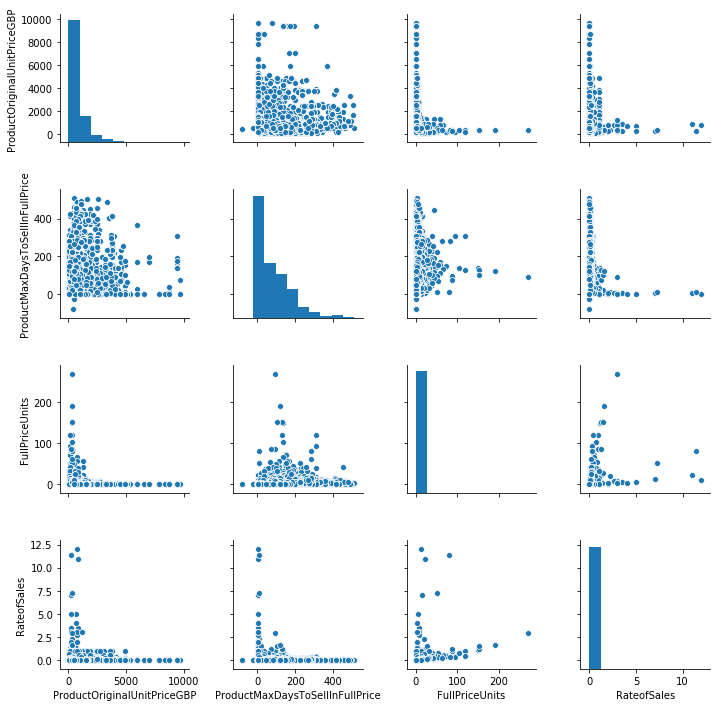

In [8]:
numeric_features = ['ProductOriginalUnitPriceGBP',
                    'ProductMaxDaysToSellInFullPrice',
                    'FullPriceUnits',
                    'RateofSales']

# sns.reset_orig()
sns.pairplot(sales_data[numeric_features]);

Observations:

- The numberical features have high skewness and not normally distributed.

## Missing Value Treatment & Data Clean Up

In [9]:
# checking for nan values

sales_data.isnull().sum()

ProductNumber                      0
ProductSkuCode                     0
ProductSize                        0
ProductDivision                    0
ProductDepartment                  0
ProductGroup                       0
ProductCategory                    0
ProductSizeGroupDescription        0
ProductOriginalUnitPriceGBP        0
ProductMaxDaysToSellInFullPrice    0
Season                             0
FullPriceUnits                     0
RateofSales                        0
dtype: int64

- There are no missing values in the data and no imputations are needed

In [10]:
# dropping unnecessary features

# sales_data_modified = sales_data.iloc[:,2:]
sales_data_modified = sales_data.drop(labels=['ProductNumber','ProductSkuCode'], axis=1)

In [11]:
# looking for negative values in the columns

negative_features =[]
negative_features.append([col for col in sales_data_modified.columns.to_list()[1:] if len(sales_data_modified[(sales_data_modified[col]<0)]) != 0])
print("The features with negative values are:\n",negative_features)

# sales_data[sales_data['ProductMaxDaysToSellInFullPrice']<0]['ProductMaxDaysToSellInFullPrice']
sales_data[sales_data['ProductMaxDaysToSellInFullPrice']<0][['ProductNumber','ProductSize','ProductMaxDaysToSellInFullPrice','FullPriceUnits','ProductOriginalUnitPriceGBP']]

The features with negative values are:
 [['ProductMaxDaysToSellInFullPrice']]


,ProductNumber,ProductSize,ProductMaxDaysToSellInFullPrice,FullPriceUnits,ProductOriginalUnitPriceGBP
309,1128,46 UK/US,-26.0,0,504.0
328,1128,50 UK/US,-26.0,0,504.0
329,1128,52 UK/US,-26.0,0,504.0
2168,1628,40 FR,-1.0,0,3339.0
2508,1128,48 UK/US,-26.0,0,504.0
2754,1628,42 FR,-1.0,0,3339.0
5670,2049,S,-81.0,0,420.0
7467,2049,M,-81.0,0,420.0
9748,2049,XS,-81.0,0,420.0
9749,2049,L,-81.0,0,420.0


The dataset doesn't have any negative values except for 'ProductMaxDaysToSellInFullPrice'. The maximum days sold on full price cannot be negative, hence we are dropping these rows.

In [12]:
# Removing all negative rows

sales_data_modified = sales_data_modified[sales_data_modified['ProductMaxDaysToSellInFullPrice']>0]

# Model Training and Validation

- As an initial step we first seperate the data into X and y

In [13]:
# Seperating dataframe to X and y

X = sales_data_modified.iloc[:,0:10]
X.head()

,ProductSize,ProductDivision,ProductDepartment,ProductGroup,ProductCategory,ProductSizeGroupDescription,ProductOriginalUnitPriceGBP,ProductMaxDaysToSellInFullPrice,Season,FullPriceUnits
0,8 UK,1,6,12,69,29,3913.0,1.0,0,0
1,44 FR,1,6,19,217,26,1085.0,1.0,0,0
2,XL,1,3,3,84,32,105.0,164.0,0,1
3,38 IT,1,6,31,152,27,637.0,1.0,0,0
4,42 IT,1,6,31,152,27,637.0,129.0,0,2


In [14]:
y = sales_data_modified['RateofSales']
y

0        0.000000
1        0.000000
2        0.006098
3        0.000000
4        0.015504
           ...   
10523    0.013889
10524    0.017094
10525    0.012500
10526    0.044944
10527    0.008403
Name: RateofSales, Length: 10518, dtype: float64

In [15]:
# Splitting the dataset to train and test
# random.seed(10)

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,random_state=0)

print("Shape of X train set:",X_train.shape)
print("Shape of X test set:",X_test.shape)
print("Shape of y train set:",y_train.shape)
print("Shape of y test set:",y_test.shape)

Shape of X train set: (7362, 10)
Shape of X test set: (3156, 10)
Shape of y train set: (7362,)
Shape of y test set: (3156,)


In [16]:
X_train.dtypes

ProductSize                         object
ProductDivision                      int64
ProductDepartment                    int64
ProductGroup                         int64
ProductCategory                      int64
ProductSizeGroupDescription          int64
ProductOriginalUnitPriceGBP        float64
ProductMaxDaysToSellInFullPrice    float64
Season                               int64
FullPriceUnits                       int64
dtype: object

## Encoding Categorical Variables

- Before we build the model, we shall encode the descrete categorical variables. We shall use the below encoders:
    - Target Encoder to encode features with many levels
    - The features 'ProductSize', 'ProductDepartment', 'ProductGroup', 'ProductCategory' have many levels and using the One-hot encoding will increase the features rapidly and we had to deal with the curse of dimensionality to fix it. Thus, we use target encoder instead which gives better results

In [17]:
high_categ = ['ProductSize','ProductDepartment','ProductGroup','ProductCategory']

for col in high_categ:
    X_train.loc[:,col] = X_train[col].astype('category')
    X_test.loc[:,col] = X_test[col].astype('category')
    
# Target encoding features with many levels
te = ce.TargetEncoder()
te.fit(X_train[high_categ],y_train)
X_train = X_train.join(te.transform(X_train[high_categ]).add_suffix('_target'))
X_test = X_test.join(te.transform(X_test[high_categ]).add_suffix('_target'))

# Dropping redundant columns
X_train.drop(high_categ, inplace= True, axis=1)
X_test.drop(high_categ, inplace= True, axis=1)

# low_categ = ['ProductDivision','Season']
# for col in low_categ:
#     X_train.loc[:,col] = X_train[col].astype('category')
# One hot encoding features with low levels
# ohe = ce.OneHotEncoder()
# ohe.fit(X_train[low_categ])
# X_train = X_train.join(ohe.transform(X_train[low_categ]))
# Dropping redundant columns
# X_train.drop(low_categ, inplace= True, axis=1)

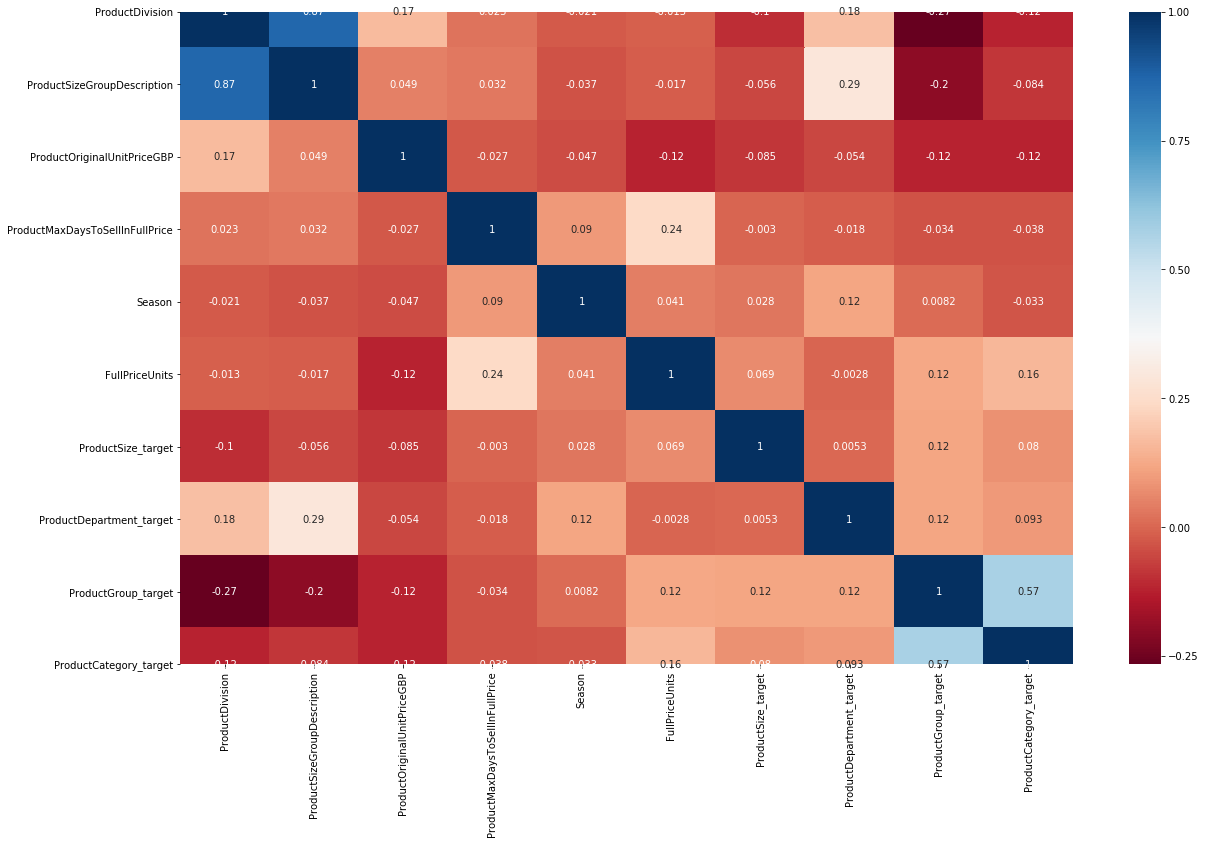

In [18]:
# Checking for multicollinearity

plt.figure(figsize=(20,12))
sns.heatmap(X_train.corr(),cmap='RdBu',annot=True);

In [129]:
# Dropping columns with high correlation

X_train.drop(['ProductSizeGroupDescription'], inplace=True, axis=1)
X_test.drop(['ProductSizeGroupDescription'], inplace=True, axis=1)

- Before building the model we need to ideally take a call to scale the data or not. We are deciding to use random forest which is a tree based model and this would not require it's input to be scaled.

## Random forest

In [140]:
# creating a parameter grid for cross validation and hyper parameter tuning
param_grid = {
    'max_depth': [50,80, 90,100],
    'min_samples_leaf': [3, 4, 5,6],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [40,50,100,150]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)

In [141]:
# finding the best parameter from our cross validation
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 192 candidates, totalling 960 fits


{'max_depth': 100,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 40}

In [142]:
# we are creating model out of the best grid generated by the cross validation
best_grid = grid_search.best_estimator_

In [143]:
# predicting the values using X_test data set
y_pred_test = best_grid.predict(X_test)

In [144]:
# predicting with the train set
y_pred_train = best_grid.predict(X_train)

# Calculating the metrics for our model performance
print('Mean Absolute Error with train set:', metrics.mean_absolute_error(y_train, y_pred_train))
print('Mean Squared Error with train set:', metrics.mean_squared_error(y_train, y_pred_train))
print('R2 score with train set:',metrics.r2_score(y_train, y_pred_train))
print('Root Mean Squared Error with train set:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

Mean Absolute Error with train set: 0.008740631266248473
Mean Squared Error with train set: 0.021176410091050216
R2 score with train set: 0.7977019195050616
Root Mean Squared Error with train set: 0.14552116715808122


### Evaluating random forest

In [145]:
# Calculating the metrics for our model performance
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_test))
print('R2 score:',metrics.r2_score(y_test, y_pred_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

Mean Absolute Error: 0.0058757696791388835
Mean Squared Error: 0.0038338180646533674
R2 score: 0.8705345044651287
Root Mean Squared Error: 0.061917833171497266


- model’s R-squared is 85%, the variance of its errors is 85% less than the variance of the dependent variable and the standard deviation of its errors is 86% less than the standard deviation of the dependent variable.

- MSE and RMSE punish larger errors more than smaller errors, inflating or magnifying the mean error score. This is due to the square of the error value. The MAE does not give more or less weight to different types of errors and instead the scores increase linearly with increases in error.

### Predicting using random forest

In [136]:
# df = pd.DataFrame({'Product Number':X_test_product_number,'Rate of Sales Real Values':y_test.reshape(-1), 'Rate of Sales Predicted Values':y_pred.reshape(-1)})

df = pd.DataFrame({'Rate of Sales Real Values':y_test, 'Rate of Sales Predicted Values':y_pred_test})
df

,Rate of Sales Real Values,Rate of Sales Predicted Values
985,0.000000,0.000000
3303,0.222222,0.234968
9350,0.046512,0.046353
4184,0.000000,0.000000
5769,0.068493,0.070681
...,...,...
7934,0.018018,0.018019
9678,0.000000,0.000000
4633,0.007634,0.007642
8377,0.025974,0.025945


### Feature importance

Feature: ProductDivision, Score: 0.00001
Feature: ProductOriginalUnitPriceGBP, Score: 0.00736
Feature: ProductMaxDaysToSellInFullPrice, Score: 0.56941
Feature: Season, Score: 0.00055
Feature: FullPriceUnits, Score: 0.34784
Feature: ProductSize_target, Score: 0.03617
Feature: ProductDepartment_target, Score: 0.00017
Feature: ProductGroup_target, Score: 0.00152
Feature: ProductCategory_target, Score: 0.03696


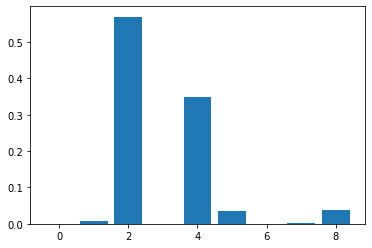

In [137]:
# Finding the important feature from the model
importance = best_grid.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (X_test.columns[i],v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

- From the above plot and values it is clear that $ProductMaxDaysToSellInFullPrice$ plays very important role in deciding the rates of sales next important feature is $FullPriceUnit$ which is quiet obvious since th formula for 

    - $ rate of sales :FullPriceUnit/ProductMaxDaysToSellInFullPrice $

- The additional data that can improve upon this is when we get more additional features specifically promotional offers, brands. This would allow us to predict more accurately.

In [138]:
rf2 = RandomForestRegressor(max_depth = 90, n_estimators = 100)
rf2.fit(X_train, y_train)
y_pred_new = rf2.predict(X_test)
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_new))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_new))
print('R2 score:',metrics.r2_score(y_test, y_pred_new))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_new)))

Mean Absolute Error: 0.004429322229392549
Mean Squared Error: 0.002589807897199184
R2 score: 0.9125439034673309
Root Mean Squared Error: 0.0508901552090302


In [139]:
y_pred_train1 = best_grid.predict(X_train)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred_train1))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred_train1))
print('R2 score:',metrics.r2_score(y_train, y_pred_train1))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train1)))

Mean Absolute Error: 0.008124601308464449
Mean Squared Error: 0.018289759214633366
R2 score: 0.8252780728212916
Root Mean Squared Error: 0.1352396362559193
